### WFCRL: A Benchmark and Interfacing tool to evaluate Reinforcement Learning Solutions for Wind Farm Control

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

from wfcrl.rewards import StepPercentage
from wfcrl import environments as envs

sns.set_theme(style="darkgrid")


Let's look at a simple environment of 7 turbines, inspired by the real wind farm of Ablaincourt, in Northern France. 

In [2]:
env = envs.make("Ablaincourt_Floris", max_num_steps=70)
print(env.num_turbines)

7


Our environment has 7 turbines. Its `action_space` defines the changes in actuators that can be made to influence the production of turbines, and its `observation_space` gives us of list of observed measures and the spaces they take value in.

In [3]:
print(env.action_space)
print(env.observation_space)

Dict('yaw': Box(-5.0, 5.0, (7,), float32))
Dict('wind_measurements': Box([3. 0.], [ 28. 360.], (2,), float32), 'yaw': Box(-20.0, 20.0, (7,), float32))


Here, we see that we can control the yaws of all 7 turbines, and we observe:
* The velocity of the undisturbed wind at the entrance of the farm, between 3 and 28 m/s
* The direction of the undisturbed wind at the entrance of the farm, between 0 and 360°.
* The current yaw commands of the system for all 7 turbines, between -20° and 20°.

Let us look at the first observation at initialization:

In [4]:
observation = env.reset()
print(observation)

OrderedDict({'yaw': array([0., 0., 0., 0., 0., 0., 0.]), 'wind_measurements': array([  8., 270.])})


Let's implement a simple step policy, that makes every turbine in the field yaw one by one.

In [5]:
def step_policy(i):
    joint_action = {"yaw": np.zeros((env.num_turbines))}
    if i % 5 == 0:
        joint_action["yaw"][int(i/5  % env.num_turbines)] = -5.0
    return joint_action

In [6]:
observation = env.reset()
r = 0
i = 0
done = False
while not done:
    joint_action = step_policy(i)
    observation, reward, termination, truncation, info = env.step(joint_action)
    r += reward
    i += 1
    done = termination or truncation
print(f"Total reward = {r}")

Total reward = [611.41961595]


We can retrieve information about the evolution of the wind farm in `env.history`

In [7]:
# Prepare plots
columns = [f"T{i+1}" for i in range(env.num_turbines)]
yaws = pd.DataFrame(np.c_[[h["yaw"] for h in env.history["observation"]]], columns=columns)
powers = pd.DataFrame(np.c_[[h for h in env.history["power"]]], columns=columns)

In [8]:
yaws.tail()

,T1,T2,T3,T4,T5,T6,T7
64,-10.0,-10.0,-10.0,-10.0,-10.0,-10.0,-5.0
65,-10.0,-10.0,-10.0,-10.0,-10.0,-10.0,-10.0
66,-10.0,-10.0,-10.0,-10.0,-10.0,-10.0,-10.0
67,-10.0,-10.0,-10.0,-10.0,-10.0,-10.0,-10.0
68,-10.0,-10.0,-10.0,-10.0,-10.0,-10.0,-10.0


[Text(0, 0.5, 'Yaw (°)'), Text(0.5, 0, 'Iterations')]

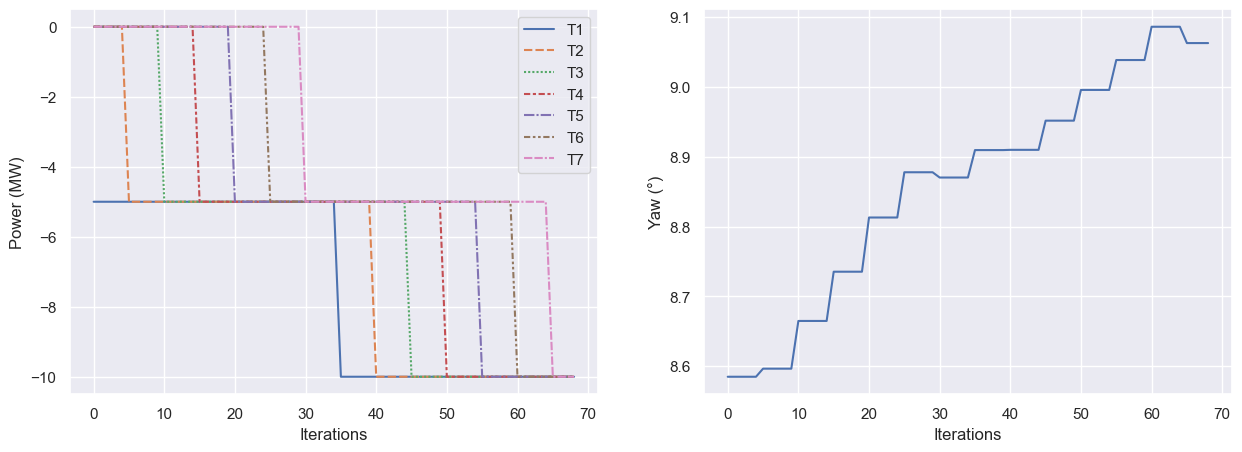

In [10]:
fig, ax = plt.subplots(ncols=2, figsize=(15, 5))
ax0 = sns.lineplot(yaws, ax=ax[0])
ax1 = sns.lineplot(powers.sum(1), ax=ax[1])
ax0.set(ylabel="Power (MW)", xlabel="Iterations")
ax1.set(ylabel="Yaw (°)", xlabel="Iterations")

### Decentralized Control

The wind farm control environment also exists in a Decentralized Control environment based on [`PettingZoo`](https://pettingzoo.farama.org/). We can access it by adding `Dec_` in front of the environment's name.

In [11]:
env = envs.make("Dec_Ablaincourt_Floris", max_num_steps=70)
env.reset()
print(env.num_turbines)
print(env.agents)

7
['turbine_1', 'turbine_2', 'turbine_3', 'turbine_4', 'turbine_5', 'turbine_6', 'turbine_7']


This is a **multi-agent environment**, where every turbine is represented by an agent. 

Let's define 7 different individual policies

In [8]:
def step_policy(i,j):
    return {"yaw": np.array([-5.0])} if i%(4*j) == 0 else {"yaw": np.zeros(1)}
def multi_agent_step_routine(env, policy):
    r = {agent: 0 for agent in env.possible_agents}
    done = {agent: False for agent in env.possible_agents}
    num_steps = {agent: 0 for agent in env.possible_agents}
    for agent in env.agent_iter():
        observation, reward, termination, truncation, info = env.last()
        done[agent] = done[agent] or termination or truncation
        r[agent] += reward
        action = policy(num_steps[agent], env.agent_name_mapping[agent])
        num_steps[agent] += 1
        env.step(action)
    return r

In [13]:
env.reset()
rewards = multi_agent_step_routine(env, step_policy)
print(f"Total rewards = {rewards}")

Total rewards = {'turbine_1': array([613.78818112]), 'turbine_2': array([613.78818112]), 'turbine_3': array([613.78818112]), 'turbine_4': array([613.78818112]), 'turbine_5': array([613.78818112]), 'turbine_6': array([613.78818112]), 'turbine_7': array([613.78818112])}


In [14]:
# Prepare plots
columns = [f"T{i+1}" for i in range(env.num_turbines)]
yaws = np.c_[[[h["yaw"] for h in env.history[agent]["observation"]]for agent in env.possible_agents]].T
powers = np.c_[[env.history[agent]["power"] for agent in env.possible_agents]].T
yaws = pd.DataFrame(yaws, columns=columns)
powers = pd.DataFrame(powers, columns=columns)

[Text(0, 0.5, 'Power (MW)'), Text(0.5, 0, 'Iterations')]

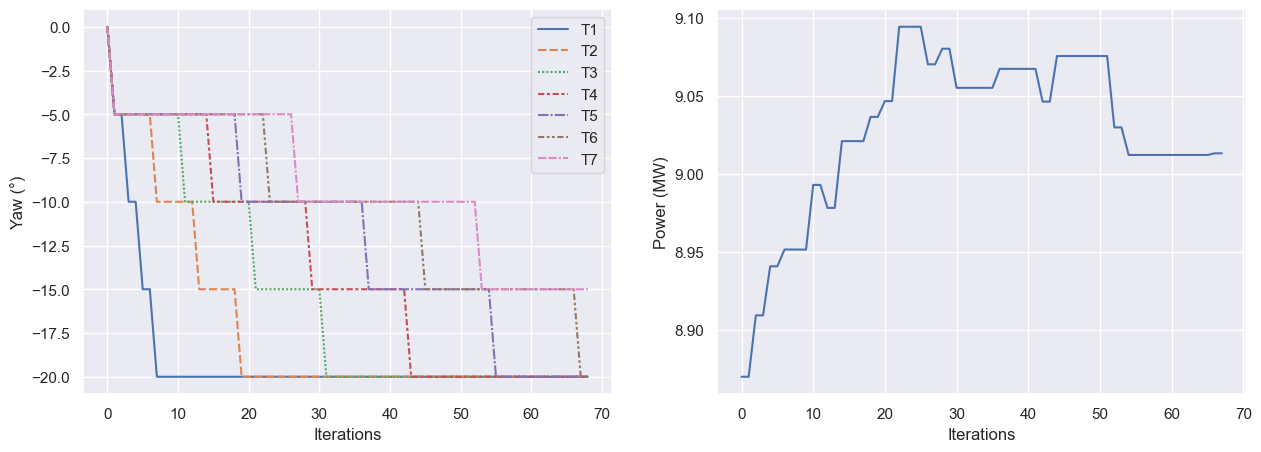

In [15]:
fig, ax = plt.subplots(ncols=2, figsize=(15, 5))
ax0 = sns.lineplot(yaws, ax=ax[0])
ax1 = sns.lineplot(powers.sum(1), ax=ax[1])
ax0.set(ylabel="Yaw (°)", xlabel="Iterations")
ax1.set(ylabel="Power (MW)", xlabel="Iterations")

### Interfacing with FastFarm

`WFCRL` implements a connexion to a simulator backend, that received actuator commands and returns simulated measures of the wind farm (of wind, yaw, pitch, load, etc.)

In [4]:
print(env.mdp.interface, env.mdp.interface.fi.configuration)

<wfcrl.interface.FlorisInterface object at 0x000002B916C39310> simulators\floris\inputs\case.yaml


The simulator backend for the `Ablaincourt_Floris` environment is the [FLORIS software](https://nrel.github.io/floris/). When we created the environment, `WFCRL` generated a simulation case contained in `simulators/floris/inputs/case.yaml`.

But FLORIS is a steady-state simulator, which does not simulate wind propagation dynamics. `WFCRL`  comes with support of the [`FAST.Farm` simulator](https://openfast.readthedocs.io/en/dev/source/user/fast.farm/index.html). 

In [5]:
ff_env = envs.make("Dec_Ablaincourt_Fastfarm", max_num_steps=100)

Deltas: [2.10730392e-05 5.68972057e-04 9.90432840e-04 1.60155098e-03
 2.19159607e-03 2.80271421e-03 3.41383234e-03]
Exception has been raise. I put this print statement instead. Check with EB.
Exception: Some X0_High are not on an integer multiple of the high-res grid
Created FAST.Farm input file: simulators/fastfarm/inputs/FarmInputs/Case.fstf


Creating an environment with the Fasftfarm backends launches a new simulation with Fastfarm ! Fastfarm is executed in background process, and communication between our environment and Fastfarm is handled by MPI !

In [6]:
ff_env.reset()

Spawning process simulators/fastfarm/bin/FAST.Farm_x64_OMP_2023.exe simulators/fastfarm/inputs/FarmInputs/Case.fstf
Interface: will receive 12 measures at every iteration


In [18]:
print(ff_env.num_turbines)
print(ff_env.agents)

7
['turbine_1', 'turbine_2', 'turbine_3', 'turbine_4', 'turbine_5', 'turbine_6', 'turbine_7']


Let's do the same routine and see the differences:

In [9]:
def ff_step_policy(i,j):
    # return {"yaw": np.zeros(1)}
    return {"yaw": np.array([5.0])} if (i == 30 and j==0) else {"yaw": np.zeros(1)}
    # return {"yaw": np.array([5.0])} if i%(2*j) == 0 else {"yaw": np.zeros(1)}

rewards = multi_agent_step_routine(ff_env, ff_step_policy)
print(f"Total rewards = {rewards}")

Total rewards = {'turbine_1': array([869.30662207]), 'turbine_2': array([869.30662207]), 'turbine_3': array([869.30662207]), 'turbine_4': array([869.30662207]), 'turbine_5': array([869.30662207]), 'turbine_6': array([869.30662207]), 'turbine_7': array([869.30662207])}


[Text(0, 0.5, 'Power (MW)'), Text(0.5, 0, 'Iterations')]

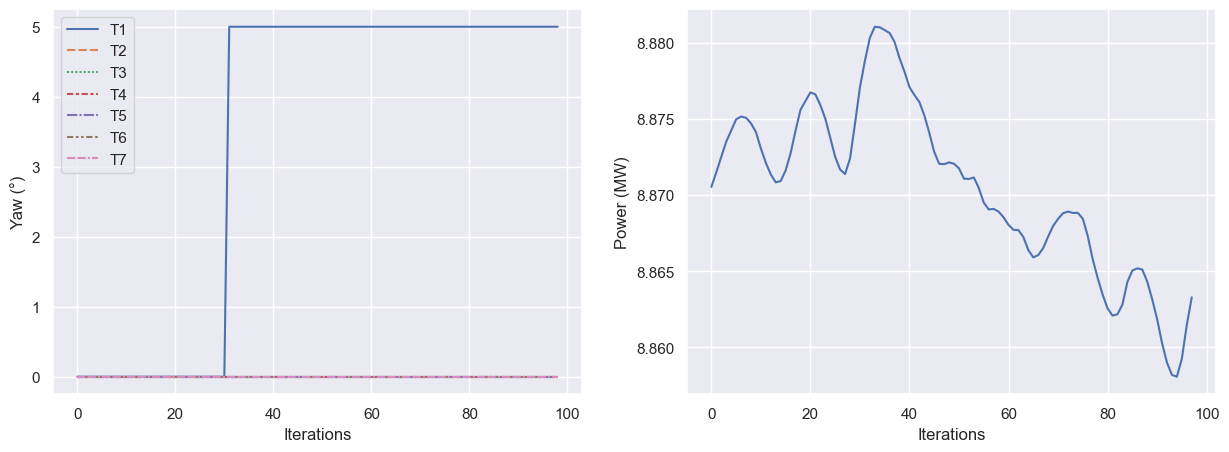

In [10]:
columns = [f"T{i+1}" for i in range(ff_env.num_turbines)]
yaws = np.c_[[[h["yaw"] for h in ff_env.history[agent]["observation"]]for agent in ff_env.possible_agents]].T
powers = np.c_[[ff_env.history[agent]["power"] for agent in ff_env.possible_agents]].T
yaws = pd.DataFrame(yaws, columns=columns)
powers = pd.DataFrame(powers, columns=columns)

fig, ax = plt.subplots(ncols=2, figsize=(15, 5))
ax0 = sns.lineplot(yaws, ax=ax[0])
ax1 = sns.lineplot(powers.sum(1), ax=ax[1])
ax0.set(ylabel="Yaw (°)", xlabel="Iterations")
ax1.set(ylabel="Power (MW)", xlabel="Iterations")

FastFarm environments allow us to chose the actuators we will control. There can be three of them: YAW, TORQUE or PITCH. For this purpose we can define a dictionary where every key is the name of the control, with the corresponding configuration, and pass it to the `env.make` function to create the environment.

```
controls = Dict(name_of_actuator : (mininum_value, maximum_value, maximum_step_at_each_iteration))
env = envs.make(name_of_case, controls=controls) 
```

By default, yaw control is activated, and the yaw can vary between -20 and 20 with a maximal step of 5°. This is equivalent to defining 

```
controls = {"yaw": (-20, 20, 5)}
```

In [21]:
ff_env.controls

{'yaw': (-20, 20, 5)}

Let's modify the maximal yaw step and activate pitch control. This wil naturally modify the observation and action space of our environment.

In [22]:
controls = {"yaw": (-20, 20, 15), "pitch": (0, 45, 1)}
ff_env = envs.make("Dec_Ablaincourt_Fastfarm", max_num_steps=100, controls=controls)

Deltas: [2.10730392e-05 5.68972057e-04 9.90432840e-04 1.60155098e-03
 2.19159607e-03 2.80271421e-03 3.41383234e-03]
Exception has been raise. I put this print statement instead. Check with EB.
Exception: Some X0_High are not on an integer multiple of the high-res grid
Created FAST.Farm input file: simulators/fastfarm/inputs/FarmInputs/Case.fstf


In [23]:
print(ff_env.controls)
print(ff_env.action_space(ff_env.possible_agents[0]))
print(ff_env.observation_space(ff_env.possible_agents[0]))

{'yaw': (-20, 20, 15), 'pitch': (0, 45, 1)}
{'pitch': Box(-1.0, 1.0, (1,), float32), 'yaw': Box(-15.0, 15.0, (1,), float32)}
{'pitch': Box(0.0, 45.0, (1,), float32), 'torque': Box(-100000.0, 100000.0, (1,), float32), 'wind_measurements': Box([3. 0.], [ 28. 360.], (2,), float32), 'yaw': Box(-20.0, 20.0, (1,), float32)}
